In [1]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import xgboost as xgb
from sklearn.metrics import r2_score

In [2]:
companies = ['AAPL']

In [2]:
companies = [
    "NFLX", "TSLA", "ORCL", "CSCO", "CRM",  # Technology
    "QCOM", "TXN", "ADBE", "SNPS", "AMAT", "NOW", "RNG", "INTC", "HPE",  # Semiconductors & Software
    "V", "MA", "C", "JPM", "WFC", "TROW", "SCHW", "CME", "MSCI",  # Financials
    "NKE", "LULU", "TJX", "COST", "HD", "LOW", "TGT", "WMT", "BBY",  # Consumer Discretionary & Retail
    "JNJ", "PFE", "MRK", "AMGN", "ABBV", "CVS", "GSK", "AZN",  # Healthcare
    "KO", "PEP", "PG", "CLX", "CAG", "SJM", "CPB",  # Consumer Staples
        "AAPL", "MSFT", "GOOGL", "META", "AMZN",  # Technology
    "NVDA", "AMD", "IBM", "INTU", "LRCX", "MU", "ADSK", "PLTR", "ZS", "PANW", "SNOW", "DDOG", "CRWD",  # Semiconductors & Software
    "PYPL", "SQ", "SHOP", "AXP", "GS", "MS", "SPGI", "BLK", "BAC",  # Financials
    "F", "GM", "DE", "RCL", "UAL", "DAL", "AAL", "BKNG", "MAR", "HLT",  # Consumer Discretionary & Travel
    "ABBV", "ABT", "BMY", "LLY", "GILD", "MRNA", "REGN", "TMO", "ISRG", "SYK", "BDX", "DHR",  # Healthcare
    "DIS", "EA", "MO", "CL", "EL", "KHC",  # Consumer Staples & Entertainment
]


In [3]:
data = pd.DataFrame()

In [ ]:
for i in companies:
    try:

        curr = yf.download(i, start='2014-10-15', end='2024-10-26')

        curr = curr.reset_index()

        curr.columns = [col[0] for col in curr.columns]

        curr.drop(columns=['Date'], inplace=True)
        empty_data = pd.DataFrame()
        result_df = calculate_tech_ind(curr, empty_data)
        data = pd.concat([data, result_df], ignore_index=True)

    except Exception as e:
        print(e, i)

In [4]:
def calculate_tech_ind(curr, data):

    data['SMA15'] = ta.sma(curr['Close'], length=15)  # Simple Moving Average
    data['EMA5'] = ta.ema(curr['Close'], length=5)    # Exponential Moving Average
    data['RSI15'] = ta.rsi(curr['Close'], length=15)  # Relative Strength Index

    # Bollinger Bands: Measures volatility with a moving average and standard deviations
    data['BB_upper'], data['BB_lower'] = ta.bbands(curr['Close'], length=56, std=2).iloc[:, [0, 2]].T.values

    # MACD and Signal Line: Trend-following momentum indicator
    data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values

    # On-Balance Volume: Volume-based trend indicator
    data['OBV'] = ta.obv(curr['Close'], curr['Volume'])

    # ADX (Average Directional Index): Measures trend strength
    data['ADX'] = ta.adx(curr['High'], curr['Low'], curr['Close']).iloc[:, 0]

    # Aroon Oscillator: Identifies trend direction and strength
    data['Aroon_Up'], data['Aroon_Down'] = ta.aroon(curr['High'], curr['Low']).iloc[:, [0, 1]].T.values
    
    uncleaned_data = pd.concat([curr, data], axis = 0)

    uncleaned_data = uncleaned_data.iloc[14:, :]

    uncleaned_data.fillna(method='ffill', inplace=True)

    uncleaned_data.fillna(method='bfill', inplace=True)

    #scaled_data = scale_data(uncleaned_data)

    #result_df = final_pcas(scaled_data)

    return uncleaned_data

In [5]:
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

In [6]:
def scale_data(uncscaled_data):
       price_columns = ['Open', 'High', 'Low']
       technical_indicators = ['SMA15', 'EMA5',
              'RSI15', 'BB_upper', 'BB_lower', 'MACD', 'MACD_signal', 'OBV', 'ADX',
              'Aroon_Up', 'Aroon_Down']
       volume_column = 'Volume'
       
       for col in price_columns:
              uncscaled_data = remove_outliers(uncscaled_data, col)
       uncscaled_data = remove_outliers(uncscaled_data, 'Close')
       
       min_max_scaler = MinMaxScaler()
       standard_scaler = StandardScaler()

       uncscaled_data[price_columns] = min_max_scaler.fit_transform(uncscaled_data[price_columns])

       uncscaled_data[volume_column] = np.log1p(uncscaled_data[volume_column])  
       uncscaled_data[[volume_column]] = min_max_scaler.fit_transform(uncscaled_data[[volume_column]])

       uncscaled_data[technical_indicators] = standard_scaler.fit_transform(uncscaled_data[technical_indicators])

       return uncscaled_data



In [8]:
scaled_data = scale_data(data)

In [155]:
def final_pcas(data):
       feature_columns = ['Open', 'High', 'Low', 'SMA15', 'EMA5',
              'RSI15', 'BB_upper', 'BB_lower', 'OBV', 'ADX',
              'Aroon_Up', 'Aroon_Down']

       X = data[feature_columns]

       pca = PCA(n_components=8)  
       X_pca = pca.fit_transform(X)

       explained_variance = pca.explained_variance_ratio_
       cumulative_variance = np.cumsum(explained_variance)


       n_components_to_keep = np.argmax(cumulative_variance >= 0.90) 
       pca_final = PCA(n_components=n_components_to_keep)
       X_final = pca_final.fit_transform(X)

       pca_columns = [f'PC{i+1}' for i in range(n_components_to_keep)]
       pca_df = pd.DataFrame(data=X_final, columns=pca_columns)
       data = pd.DataFrame(data=data, columns=['MACD', 'MACD_signal', 'Close'])
       result_df = pd.concat([data.reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1)

       return result_df


In [ ]:
#data = final_pcas(data)

In [9]:
data

,Adj Close,Close,High,Low,Open,Volume,SMA15,EMA5,RSI15,BB_upper,BB_lower,MACD,MACD_signal,OBV,ADX,Aroon_Up,Aroon_Down
0,54.682858,54.682858,55.321430,54.110001,55.274284,11389700.0,54.495143,54.074001,35.398389,44.818547,58.228035,-0.235571,-0.480964,59927700.0,24.785329,7.142857,0.000000
1,54.340000,54.340000,55.405712,53.770000,55.087143,13645800.0,54.495143,54.074001,35.398389,44.818547,58.228035,-0.235571,-0.480964,59927700.0,24.785329,7.142857,0.000000
2,54.757141,54.757141,55.047142,53.907143,54.000000,9991800.0,54.495143,54.074001,35.398389,44.818547,58.228035,-0.235571,-0.480964,59927700.0,24.785329,7.142857,0.000000
3,54.880001,54.880001,55.035713,54.185715,54.777142,9303700.0,54.495143,54.074001,35.398389,44.818547,58.228035,-0.235571,-0.480964,59927700.0,24.785329,7.142857,0.000000
4,55.324287,55.324287,55.635715,54.142857,54.714287,9711100.0,54.495143,54.074001,35.398389,44.818547,58.228035,-0.235571,-0.480964,59927700.0,24.785329,7.142857,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496977,34.740002,34.740002,35.090000,34.599998,34.910000,7532900.0,35.106667,35.658463,54.479545,34.134156,36.266915,0.187734,0.118805,-270546900.0,16.586129,14.285714,100.000000
496978,34.740002,34.740002,35.090000,34.599998,34.910000,7532900.0,35.138000,35.652308,56.443074,34.145194,36.240877,0.192721,0.099033,-262881400.0,17.134809,7.142857,92.857143
496979,34.740002,34.740002,35.090000,34.599998,34.910000,7532900.0,35.213334,35.601539,54.109050,34.147401,36.249385,0.183263,0.071661,-268739500.0,17.040110,0.000000,85.714286
496980,34.740002,34.740002,35.090000,34.599998,34.910000,7532900.0,35.270667,35.411026,47.102914,34.155087,36.249199,0.136272,0.019736,-276722700.0,17.207409,0.000000,78.571429


In [10]:
scaled_data

,Adj Close,Close,High,Low,Open,Volume,SMA15,EMA5,RSI15,BB_upper,BB_lower,MACD,MACD_signal,OBV,ADX,Aroon_Up,Aroon_Down
0,54.682858,54.682858,0.146908,0.155294,0.147858,0.737560,-0.312031,-0.302415,-1.553938,-0.419486,-0.361782,-0.486875,-0.757586,-0.110158,-0.560007,-0.504183,-1.907151
1,54.340000,54.340000,0.147134,0.154310,0.147353,0.745764,-0.312031,-0.302415,-1.553938,-0.419486,-0.361782,-0.486875,-0.757586,-0.110158,-0.560007,-0.504183,-1.907151
2,54.757141,54.757141,0.146174,0.154707,0.144419,0.731616,-0.312031,-0.302415,-1.553938,-0.419486,-0.361782,-0.486875,-0.757586,-0.110158,-0.560007,-0.504183,-1.907151
3,54.880001,54.880001,0.146143,0.155513,0.146516,0.728377,-0.312031,-0.302415,-1.553938,-0.419486,-0.361782,-0.486875,-0.757586,-0.110158,-0.560007,-0.504183,-1.907151
4,55.324287,55.324287,0.147750,0.155389,0.146347,0.730323,-0.312031,-0.302415,-1.553938,-0.419486,-0.361782,-0.486875,-0.757586,-0.110158,-0.560007,-0.504183,-1.907151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496977,34.740002,34.740002,0.092705,0.098807,0.092905,0.718793,-0.660729,-0.633461,-0.490941,-0.634627,-0.718277,-0.286923,0.230450,-0.175581,-0.995394,-0.288126,0.917814
496978,34.740002,34.740002,0.092705,0.098807,0.092905,0.718793,-0.660166,-0.633571,-0.381554,-0.634405,-0.718700,-0.284567,0.197878,-0.174064,-0.966258,-0.504183,0.716030
496979,34.740002,34.740002,0.092705,0.098807,0.092905,0.718793,-0.658811,-0.634484,-0.511581,-0.634360,-0.718562,-0.289035,0.152786,-0.175224,-0.971287,-0.720239,0.514247
496980,34.740002,34.740002,0.092705,0.098807,0.092905,0.718793,-0.657780,-0.637909,-0.901888,-0.634205,-0.718565,-0.311232,0.067246,-0.176804,-0.962403,-0.720239,0.312464


In [11]:
target_regression = scaled_data['Close']

In [12]:
target_classification = (scaled_data['Close'].shift(-1) > scaled_data['Close']).astype(int)

In [15]:
input = scaled_data

In [25]:
input.drop(columns=['Close', 'Adj Close'], inplace=True)

In [16]:
target_regression

0         54.682858
1         54.340000
2         54.757141
3         54.880001
4         55.324287
            ...    
496977    34.740002
496978    34.740002
496979    34.740002
496980    34.740002
496981    34.740002
Name: Close, Length: 420972, dtype: float64

In [17]:
target_classification

0         0
1         1
2         1
3         1
4         0
         ..
496977    0
496978    0
496979    0
496980    0
496981    0
Name: Close, Length: 420972, dtype: int32

In [18]:
input

,High,Low,Open,Volume,SMA15,EMA5,RSI15,BB_upper,BB_lower,MACD,MACD_signal,OBV,ADX,Aroon_Up,Aroon_Down
0,0.146908,0.155294,0.147858,0.737560,-0.312031,-0.302415,-1.553938,-0.419486,-0.361782,-0.486875,-0.757586,-0.110158,-0.560007,-0.504183,-1.907151
1,0.147134,0.154310,0.147353,0.745764,-0.312031,-0.302415,-1.553938,-0.419486,-0.361782,-0.486875,-0.757586,-0.110158,-0.560007,-0.504183,-1.907151
2,0.146174,0.154707,0.144419,0.731616,-0.312031,-0.302415,-1.553938,-0.419486,-0.361782,-0.486875,-0.757586,-0.110158,-0.560007,-0.504183,-1.907151
3,0.146143,0.155513,0.146516,0.728377,-0.312031,-0.302415,-1.553938,-0.419486,-0.361782,-0.486875,-0.757586,-0.110158,-0.560007,-0.504183,-1.907151
4,0.147750,0.155389,0.146347,0.730323,-0.312031,-0.302415,-1.553938,-0.419486,-0.361782,-0.486875,-0.757586,-0.110158,-0.560007,-0.504183,-1.907151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496977,0.092705,0.098807,0.092905,0.718793,-0.660729,-0.633461,-0.490941,-0.634627,-0.718277,-0.286923,0.230450,-0.175581,-0.995394,-0.288126,0.917814
496978,0.092705,0.098807,0.092905,0.718793,-0.660166,-0.633571,-0.381554,-0.634405,-0.718700,-0.284567,0.197878,-0.174064,-0.966258,-0.504183,0.716030
496979,0.092705,0.098807,0.092905,0.718793,-0.658811,-0.634484,-0.511581,-0.634360,-0.718562,-0.289035,0.152786,-0.175224,-0.971287,-0.720239,0.514247
496980,0.092705,0.098807,0.092905,0.718793,-0.657780,-0.637909,-0.901888,-0.634205,-0.718565,-0.311232,0.067246,-0.176804,-0.962403,-0.720239,0.312464


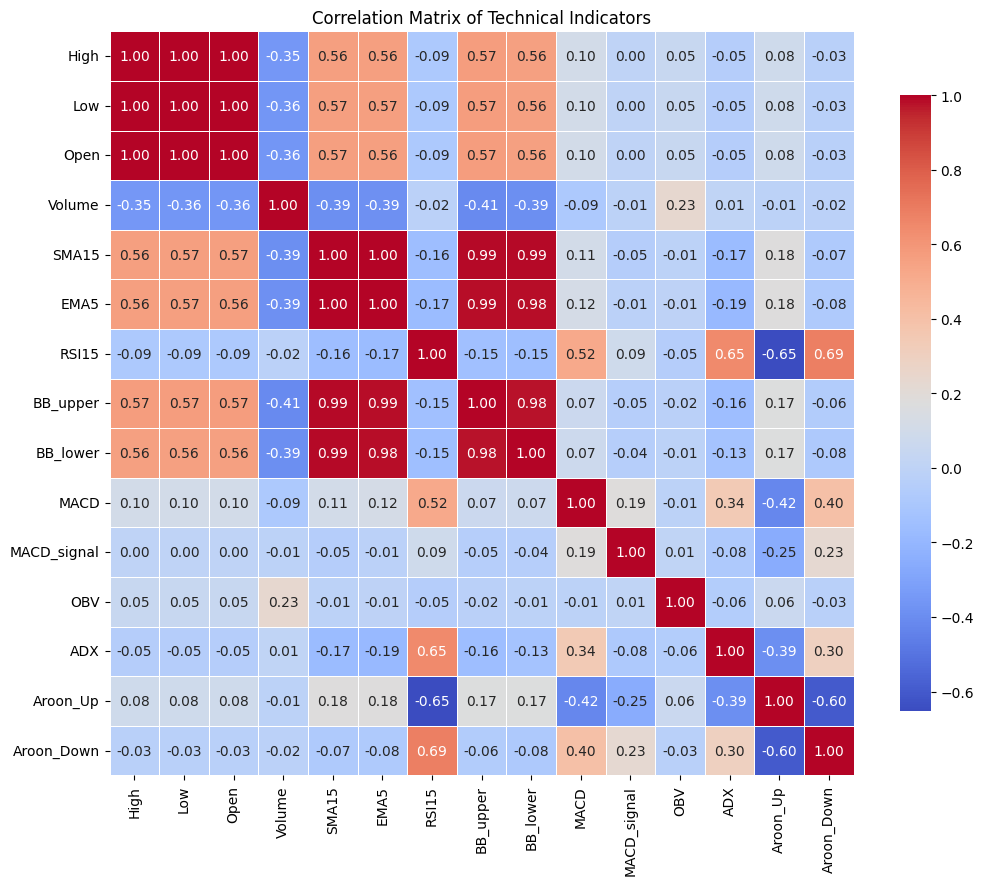

In [19]:
correlation_matrix = input.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, cbar_kws={"shrink": .8}, linewidths=.5)

# Title and show the plot
plt.title('Correlation Matrix of Technical Indicators')
plt.show()


-----------
Regressor
----------

In [41]:
X_train, X_test, y_train, y_test = train_test_split(input, target_regression, test_size=0.2, random_state=42)

In [32]:
# Train XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Get feature importance scores
feature_importance = xgb_model.feature_importances_
important_features = X_train.columns[feature_importance > 0.01]
print(feature_importance, important_features)

[4.9754670e-01 5.0220275e-01 7.1220718e-05 1.4665841e-05 1.2902567e-05
 2.5002604e-05 1.8220662e-05 7.3671381e-06 5.3173258e-06 6.7508795e-06
 8.2526776e-06 3.7084821e-05 1.8567038e-05 1.9624269e-05 5.5885539e-06] Index(['High', 'Low'], dtype='object')


In [33]:

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

Mean Squared Error (MSE): 0.8859314742455221
Root Mean Squared Error (RMSE): 0.9412393288879944


In [34]:
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

print(results.sample())

R² Score: 0.9998626760534819


In [43]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',  # for regression
                           cv=5,
                           verbose=1)

grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Mean Squared Error (MSE): 0.8614451805927091
Root Mean Squared Error (RMSE): 0.9281407116341299


-----------
Classifier
-----------

In [36]:
X_train, X_test, y_train, y_test = train_test_split(input, target_classification, test_size=0.2, random_state=42)

In [37]:
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7380723320862284


In [39]:
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1)

grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1.0}


In [40]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.7385474196805036
